In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_glm import Sub_Clust_Cos_GLM
from models.clust_gru import Clust_GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [3]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 4
#E_no = 2000
#I_no = 200
E_no = 299
I_no = 8
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9950*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
#model = Clust_GRU(sub_no, E_no, I_no, H_no, device)
syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw") or (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

optimizer = torch.optim.Adam(rest_params, lr = 0.005/(1.05**100))
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005)

milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.025)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.05)
syn_scheduler = torch.optim.lr_scheduler.StepLR(syn_optimizer, step_size=increment, gamma=0.975)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

print(sum(p.numel() for p in syn_params if p.requires_grad))
print(sum(p.numel() for p in rest_params if p.requires_grad))
print(milestones.shape)

1936
1228
708
(100,)


In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

score_list = []
temp_list = np.logspace(0,-3,100)
temp_count = 0

beta = 1
kl_ref_e = torch.ones(sub_no, E_no).to(device) * 1/sub_no
kl_ref_i = torch.ones(sub_no, I_no).to(device) * 1/sub_no
kl_ref = torch.ones(sub_no).to(device) * 1/sub_no
kl_criterion = nn.KLDivLoss()

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    syn_optimizer.zero_grad()
    
    if (temp_count < 99) & (i%increment == increment-1):
        temp_count += 1
    temp = temp_list[temp_count]
    if i%(increment//2) == (increment//2)-1:
        beta *= 0.975
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _, _, _, log_C_syn_e, log_C_syn_i = model(batch_E_neural, batch_I_neural, temp)    
    V_pred, _, C_syn_e, C_syn_i, log_C_syn_e, log_C_syn_i  = model(batch_E_neural[:,:,e_idx], batch_I_neural[:,:,i_idx], temp)    
    
    mse_loss = torch.mean((V_pred - batch_V[:,:])**2)
    #kl_loss = kl_criterion(log_C_syn_e, kl_ref_e) + kl_criterion(log_C_syn_i, kl_ref_i)
    log_probs = torch.log(torch.sum(C_syn_e, 1)/torch.sum(C_syn_e))
    kl_loss = kl_criterion(log_probs, kl_ref)
    
    loss = mse_loss + beta*kl_loss
    
    loss.backward()
    optimizer.step()
    syn_optimizer.step()
    #scheduler.step()
    syn_scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i, _, _ = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), 0.0001)
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i, _, _ = model(test_E_neural.unsqueeze(0)[:,:,e_idx], test_I_neural.unsqueeze(0)[:,:,i_idx], 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
        
        #C_syn_idx = torch.argmax(test_C_syn_e[:,880:1120], 0).float()
        C_syn_idx = torch.argmax(test_C_syn_e, 0).float()
                        
        """
        print(i, np.round(test_score,6),
              np.round(torch.mean(C_syn_idx[:60]).item(), 4),
             np.round(torch.mean(C_syn_idx[60:120]).item(), 4),
             np.round(torch.mean(C_syn_idx[120:180]).item(), 4),
             np.round(torch.mean(C_syn_idx[180:240]).item(), 4))
        print(np.round(torch.var(C_syn_idx[:60]).item(), 4),
             np.round(torch.var(C_syn_idx[60:120]).item(), 4),
             np.round(torch.var(C_syn_idx[120:180]).item(), 4),
             np.round(torch.var(C_syn_idx[180:240]).item(), 4))
        print("------------------------")
        """
        print(i, np.round(test_score,6),
              np.round(1/temp, 6),
            np.round(kl_loss.item(), 6),
             np.round(beta, 6))
        print(np.round(torch.mean(C_syn_idx[29:89]).item(), 4),
             np.round(torch.mean(C_syn_idx[89:149]).item(), 4),
             np.round(torch.mean(C_syn_idx[149:209]).item(), 4),
             np.round(torch.mean(C_syn_idx[209:269]).item(), 4))
        print(np.round(torch.var(C_syn_idx[29:89]).item(), 4),
             np.round(torch.var(C_syn_idx[89:149]).item(), 4),
             np.round(torch.var(C_syn_idx[149:209]).item(), 4),
             np.round(torch.var(C_syn_idx[209:269]).item(), 4))
        print("------------------------")
          

0 0.005436 1.0 0.0 1
1.9167 1.75 1.9167 1.8167
1.2641 1.411 1.3658 1.3387
------------------------
49 0.097367 1.072267 0.0 0.950625
1.2833 1.4833 1.6333 1.8
0.4099 0.3895 0.3379 0.3322
------------------------
99 0.124825 1.149757 0.0 0.903688
1.2333 1.5 1.7667 2.0
0.4192 0.661 0.4192 0.0
------------------------
149 0.138265 1.232847 0.0 0.859068
1.0 1.1167 1.2667 1.9833
0.0 0.3082 1.0463 0.1862
------------------------
199 0.160082 1.321941 0.0 0.816652
1.0667 1.55 0.1667 0.2167
0.1311 0.8958 0.4124 0.4438
------------------------
249 0.189278 1.417474 0.0 0.77633
1.1333 2.4833 0.1833 0.3
0.2531 0.8641 0.3895 0.5186
------------------------
299 0.199262 1.519911 1e-06 0.737998
1.0667 2.75 0.35 0.3667
0.1311 0.5297 0.6381 0.609
------------------------
349 0.208974 1.629751 2e-06 0.70156
1.0 2.75 0.4833 0.3167
0.0 0.5297 0.7963 0.6946
------------------------
399 0.214335 1.747528 5e-06 0.66692
1.0 2.6167 0.6167 0.3333
0.0 0.715 0.9184 0.7684
------------------------
449 0.218321 1.8

KeyboardInterrupt: 

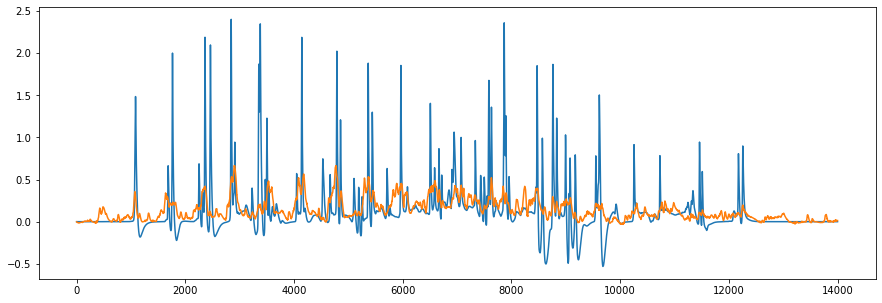

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:30000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:30000])

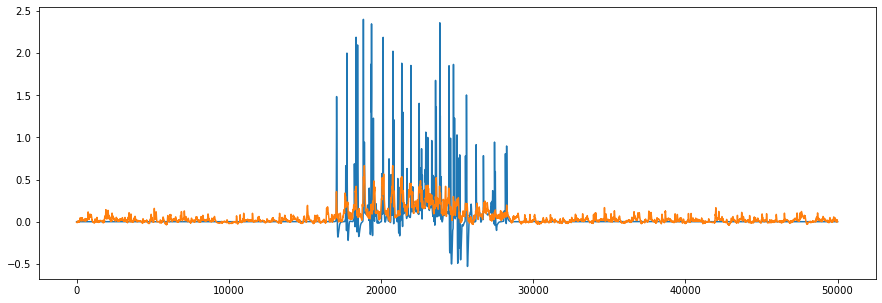

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy())

In [9]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)
kern_e = kern_e.cpu().detach().numpy()
kern_i = kern_i.cpu().detach().numpy()

scale_e = model.E_scale.cpu().detach().numpy()
scale_i = model.I_scale.cpu().detach().numpy()

C_syn_e = test_C_syn_e.cpu().detach().numpy()
C_syn_i = test_C_syn_i.cpu().detach().numpy()

print(kern_e.shape)
print(kern_i.shape)
print(scale_e.shape)
print(scale_i.shape)

(8, 500)
(8, 500)
(299,)
(8,)


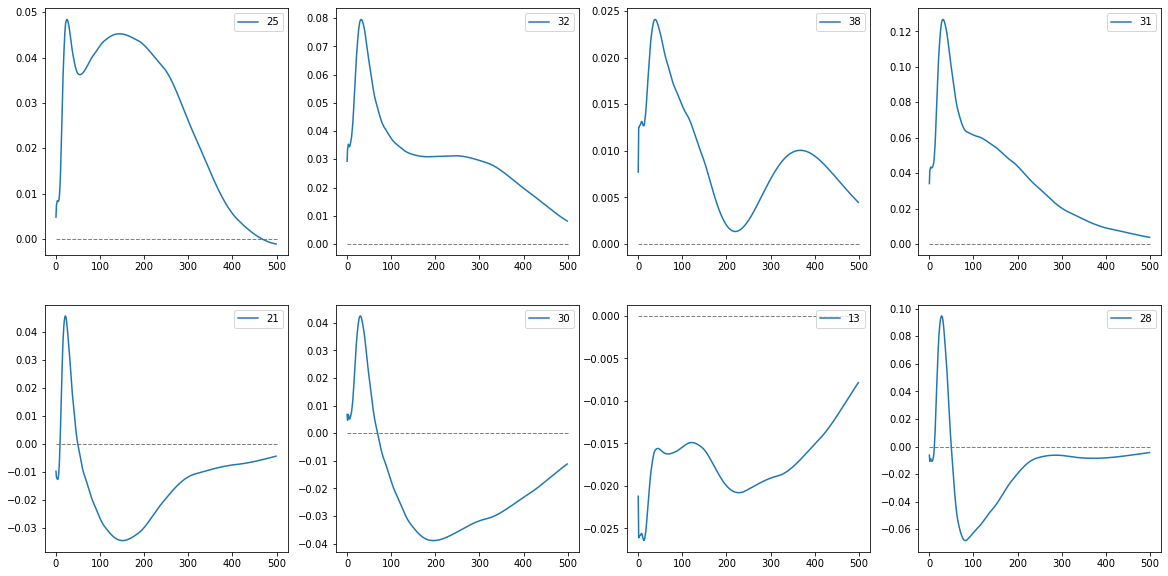

In [10]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[i,j].plot(kern_e[idx], label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

In [11]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(model.C_syn_e_raw[:,e])

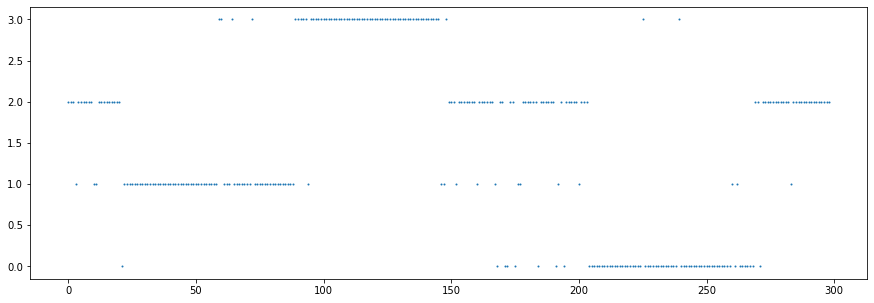

In [12]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

ValueError: x and y must be the same size

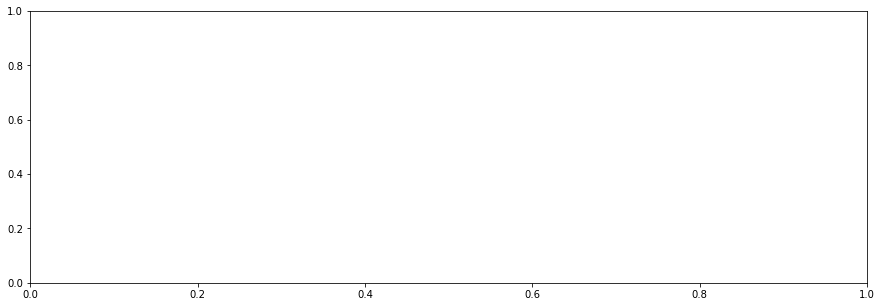

In [13]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

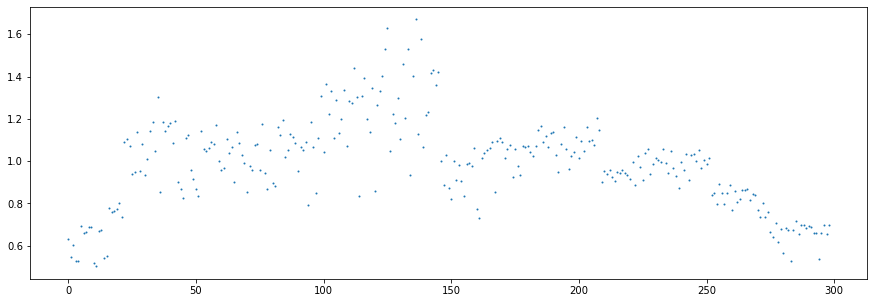

In [14]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [18]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2.pt")

#np.savez("/media/hdd01/sklee/CA1_clust4-60/glm_diff_clust_s8_h2_output.npz",
         test = test_V_pred.cpu().detach().numpy().flatten(),
         kern_e = kern_e,
         kern_i = kern_i,
         scale_e = scale_e,
         scale_i = scale_i,
         C_syn_e = C_syn_e,
         C_syn_i = C_syn_i)